#### Import necessary libraries

In [1]:
import scanpy as sc
import hdf5plugin
import numpy as np
import pandas as pd
import decoupler as dc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### Initialize utility functions

In [2]:
def create_marker_dict(df_cellmarker, cell_name="cell_name", marker="Symbol"):
    cell_markers = {}
    for i in list(set(df_cellmarker[cell_name].values.tolist())):
        genes = df_cellmarker[df_cellmarker[cell_name]==i][marker].values.tolist()
        cell_markers[i] = genes
    return cell_markers


def create_melted_df(score_df, ctype_lst):
    # Step 1: Creating separate DataFrames for each cluster
    cluster_dfs = [score_df[score_df['cluster'] == str(i)] for i in range(len(score_df["cluster"].value_counts()))]

    # Step 2: Adding a 'dataset' column
    dfs = [df.assign(dataset=f'dataset_{i}') for i, df in enumerate(cluster_dfs)]

    # Checking the assignment of the 'dataset' column

    # Step 3: Concatenating DataFrames into one
    final_df = pd.concat(dfs, ignore_index=True)

    # Confirming that the 'dataset' column is present in the concatenated DataFrame


    # Step 4: Melting the DataFrame for seaborn plotting
    final_df_melted = final_df.melt(id_vars=['dataset', 'cluster'], 
                                    value_vars=ctype_lst,
                                    var_name='cell_type',
                                    value_name='score')

    # Ensuring the melted DataFrame looks as expected
    return final_df_melted


def cluster_vln_plot(melted_df):
    # Plotting
    plt.figure(figsize=(16, 6))
    ax = sns.violinplot(x='cluster', y='score', hue='cell_type', data=melted_df, 
                   inner="quartile", palette="muted", scale="count")

    # Ensuring gridlines are below plot elements
    ax.set_axisbelow(True)

    # Adding gridlines
    ax.yaxis.grid(True, color="gainsboro", linestyle="dashed")  # Horizontal gridlines

    # Compute midpoints between x-tick labels for grid placement
    xticks = ax.get_xticks()
    midpoints = (xticks[:-1] + xticks[1:]) / 2

    # Add vertical gridlines at midpoints
    ax.vlines(midpoints, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], colors='lightgray', linestyles='solid', linewidth=0.5)

    # Customizing other plot elements
    # ax.set_facecolor("lightgray")
    plt.gca().set_facecolor("whitesmoke")

    plt.title(f'Violin plots of cell-type ORA scores across leiden clusters')
    plt.ylabel('ORA score')
    plt.xlabel('Leiden cluster')

    plt.legend(title='Cell Type', bbox_to_anchor=(1.01, 1), loc='upper left')

    legend = ax.get_legend()


# Save the currently active figure with high DPI
    plt.savefig('./ora_violins_600dpi.png', 
                dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
    
    
#     plt.tight_layout()
    plt.show()
    
    

def cluster_vln_plot2(melted_df, specific_cluster):
    # Filter the DataFrame for the specific cluster
    filtered_df = melted_df[melted_df['cluster'] == specific_cluster]

    # Initialize the matplotlib figure
    plt.figure(figsize=(8, 6))

    # Create the violin plot
    ax = sns.violinplot(x='cell_type', y='score', data=filtered_df, inner="quartile", palette="muted", scale="width")

    # Customize the axes and grid
    ax.set_xlabel('Cell Type')
    ax.set_ylabel('ORA score')
    ax.grid(axis='y', linestyle='--', color='grey', linewidth=0.7, alpha=0.7)

    # Set the title of the plot
    plt.title(f'Violin plot of cell-type ORA scores for cluster {specific_cluster}')

    # Adjust the plot to ensure everything fits well
    plt.tight_layout()

    # Show the plot
    plt.show()

#### Parameters

In [3]:
CLUSTER_RESOLUTION = 0.25

#### Paths for marker genes, integrated anndata object and final anndata object (cell-type annotation result)

In [4]:
H5AD_PATH = "./data/h5ad_integrat/alzheimer_data_scanorama_v1.h5ad"
MARKER_GENES = "./data/brain_markers.csv"

#### Read integrated anndata object from disk

In [5]:
adata = sc.read_h5ad(H5AD_PATH)
adata

AnnData object with n_obs × n_vars = 37380 × 22915
    obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch'
    var: 'gene_ids'
    uns: 'batch_colors', 'condition_colors', 'neighbors', 'umap'
    obsm: 'Scanorama', 'X_umap'
    obsp: 'connectivities', 'distances'

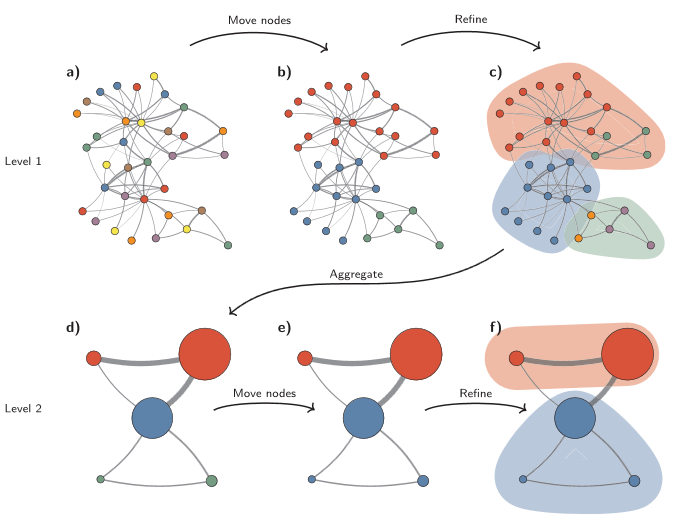

In [6]:
sc.tl.leiden(adata, resolution = CLUSTER_RESOLUTION, key_added = "leiden")

#### Read list of markers and cell types into a pandas dataframe

In [7]:
cell_markers = pd.read_csv(MARKER_GENES)
cell_markers = cell_markers.drop_duplicates()
cell_markers

,cell_name,Symbol
0,Vascular smooth muscle cell(VSMC),ACTA2
1,Astrocyte,CD80
2,Astrocyte,CD86
3,Astrocyte,CD40
4,Astrocyte,GFAP
...,...,...
993,Oligodendrocyte,QKI
994,Oligodendrocyte,PCDH9
995,Neuron,NCAM2
996,Neuron,SHISA9


<Axes: title={'center': 'Leiden Clustering'}, xlabel='UMAP1', ylabel='UMAP2'>

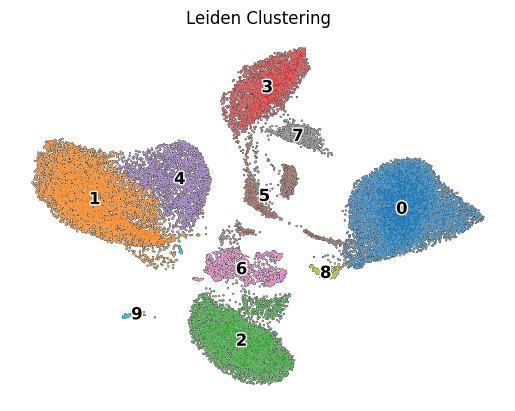

In [9]:
sc.pl.umap(adata, color='leiden', add_outline=True, legend_loc="on data",
           legend_fontsize=12, legend_fontoutline=2,frameon=False, title='Leiden Clustering', show=False)

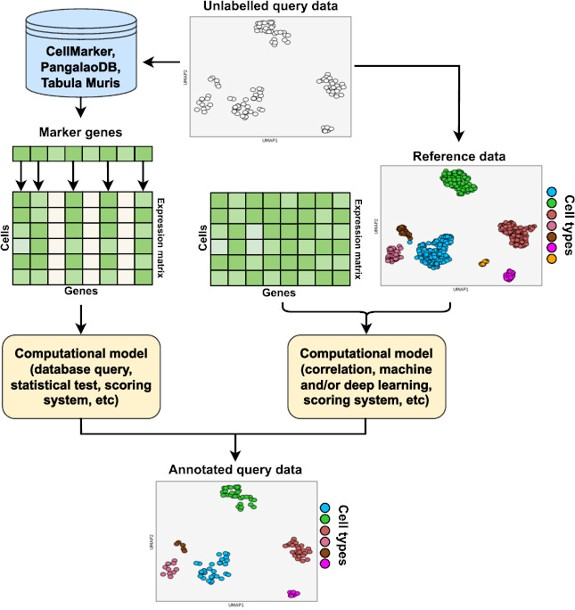

#### Enrichment with Over Representation Analysis (ORA)

In [10]:
dc.run_ora(
    mat=adata,
    net=cell_markers,
    source='cell_name',
    target='Symbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

Running ora on mat with 37380 samples and 22915 targets for 8 sources.


  0%|          | 0/37380 [00:00<?, ?it/s]

#### The obtained scores (-log10(p-value))(ora_estimate) and p-values (ora_pvals) are stored in the .obsm key

In [11]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 37380 × 8
    obs: 'condition', 'n_genes', 'prc_mt', 'prc_rb', 'n_counts', 'batch', 'leiden'
    uns: 'batch_colors', 'condition_colors', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'Scanorama', 'X_umap', 'ora_estimate', 'ora_pvals'

#### Create cell-type list and ORA-score dataframe

In [12]:
score_df = adata.obsm['ora_estimate']
ctype_lst = list(score_df.columns)
score_df["cluster"] = adata.obs["leiden"]
ctype_lst

['Astrocyte',
 'Endothelial cell',
 'Fibroblast',
 'Microglial cell',
 'Neuron',
 'Oligodendrocyte',
 'Pericyte',
 'Vascular smooth muscle cell(VSMC)']

#### Create ORA-score violin plots for all leiden clusters and cell-types

#### Visualize the obtained ORA scores

In [15]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,Microglial cell,154.742554,2.211042,0.000000,0.000000
1,0,rest,Vascular smooth muscle cell(VSMC),21.681149,0.053894,0.000000,0.000000
2,0,rest,Fibroblast,-30.916334,-0.071409,0.000000,0.000000
3,0,rest,Pericyte,-33.373825,-0.112959,0.000000,0.000000
4,0,rest,Endothelial cell,-37.687080,-0.719846,0.000000,0.000000
...,...,...,...,...,...,...,...
75,9,rest,Pericyte,-1.494252,-0.047948,0.137354,0.137354
76,9,rest,Vascular smooth muscle cell(VSMC),-2.110664,-0.040227,0.036658,0.041895
77,9,rest,Astrocyte,-2.222472,-1.873464,0.027618,0.036824
78,9,rest,Microglial cell,-3.727998,-0.583153,0.000273,0.000545


In [16]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Microglial cell', 'Vascular smooth muscle cell(VSMC)', 'Fibroblast'],
 '1': ['Astrocyte', 'Neuron', 'Pericyte'],
 '2': ['Oligodendrocyte', 'Neuron', 'Pericyte'],
 '3': ['Endothelial cell', 'Fibroblast', 'Pericyte'],
 '4': ['Astrocyte', 'Neuron', 'Vascular smooth muscle cell(VSMC)'],
 '5': ['Pericyte', 'Fibroblast', 'Vascular smooth muscle cell(VSMC)'],
 '6': ['Neuron', 'Fibroblast', 'Oligodendrocyte'],
 '7': ['Endothelial cell', 'Microglial cell', 'Fibroblast'],
 '8': ['Vascular smooth muscle cell(VSMC)', 'Endothelial cell', 'Fibroblast'],
 '9': ['Neuron', 'Oligodendrocyte', 'Fibroblast']}

In [17]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'Microglial cell',
 '1': 'Astrocyte',
 '2': 'Oligodendrocyte',
 '3': 'Endothelial cell',
 '4': 'Astrocyte',
 '5': 'Pericyte',
 '6': 'Neuron',
 '7': 'Endothelial cell',
 '8': 'Vascular smooth muscle cell(VSMC)',
 '9': 'Neuron'}

In [18]:
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

<Axes: title={'center': 'Cell-types (decoupleR Annotation)'}, xlabel='UMAP1', ylabel='UMAP2'>

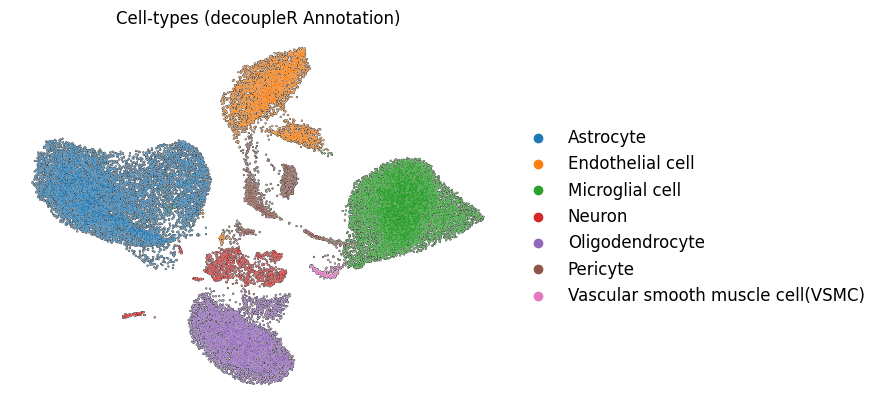

In [ ]:
sc.pl.umap(adata, 
           color='cell_type', 
           add_outline=True, 
#            legend_loc="on data",
           legend_fontsize=12, 
           legend_fontoutline=2,
           frameon=False, 
           title='Cell-types (decoupleR Annotation)', 
           show=False)